In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_4378.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_747.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_561.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_345.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3019.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_2566.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3156.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3889.jpg
/kaggle/input/human-action-recognition-har-dataset

# 2| Importing libraries

In [3]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 3| Getting the path and Loading the data

In [4]:
train_data = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")
test_data = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")

In [5]:
train_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/train/*") 
test_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/test/*")

In [6]:
train_data

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [7]:
train_data.label.value_counts()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

In [8]:
import plotly.express as px
HAR = train_data.label.value_counts()
fig = px.pie(train_data, values=HAR.values, names=HAR.index, title='Distribution of Human Activity')
fig.show()

In [9]:
filename = train_data['filename']

situation = train_data['label']

In [10]:
filename

0            Image_1.jpg
1            Image_2.jpg
2            Image_3.jpg
3            Image_4.jpg
4            Image_5.jpg
              ...       
12595    Image_12596.jpg
12596    Image_12597.jpg
12597    Image_12598.jpg
12598    Image_12599.jpg
12599    Image_12600.jpg
Name: filename, Length: 12600, dtype: object

# 4| Making function that take random path and display the image

In [11]:
def displaying_random_images():
    num = random.randint(1,10000)
    imgg = "Image_{}.jpg".format(num)
    train = "../input/human-action-recognition-har-dataset/Human Action Recognition/train/"
    if os.path.exists(train+imgg):
        testImage = img.imread(train+imgg)
        plt.imshow(testImage)
        plt.title("{}".format(train_data.loc[train_data['filename'] == "{}".format(imgg), 'label'].item()))

    else:
        #print(train+img)
        print("File Path not found \nSkipping the file!!")

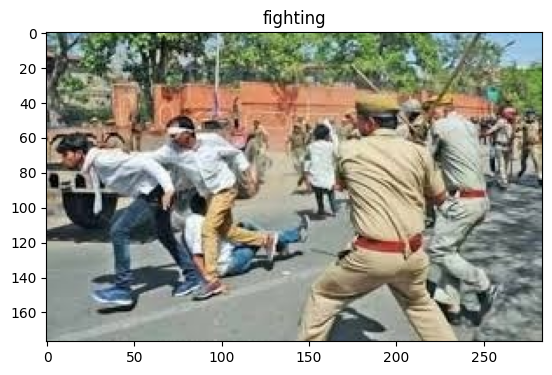

In [12]:
displaying_random_images()

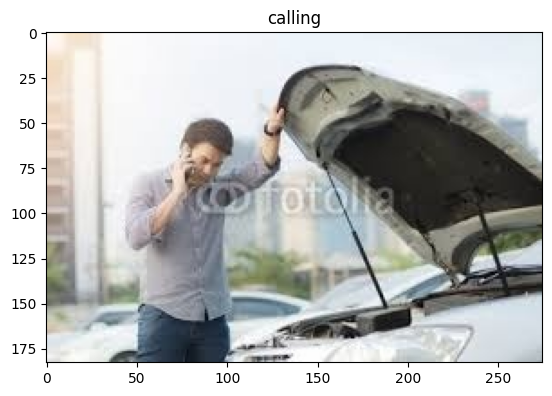

In [13]:
displaying_random_images()

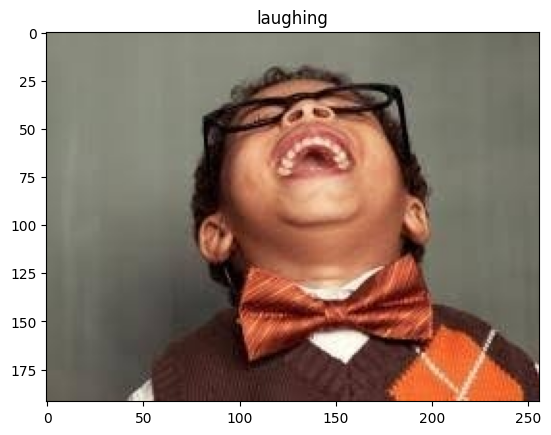

In [14]:
displaying_random_images()

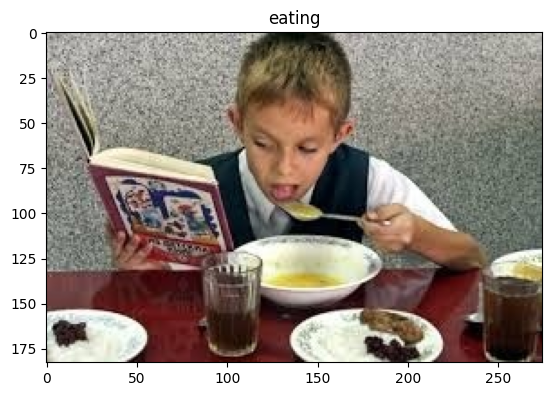

In [15]:
displaying_random_images()

# 5| Data preprocessing

In [16]:
img_data = []
img_label = []
length = len(train_fol)
for i in (range(len(train_fol)-1)):
    t = '../input/human-action-recognition-har-dataset/Human Action Recognition/train/' + filename[i]    
    temp_img = Image.open(t)
    img_data.append(np.asarray(temp_img.resize((160,160))))
    img_label.append(situation[i])

In [17]:
img_shape= (160,160,3)

In [18]:
iii = img_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [19]:
y_train = to_categorical(np.asarray(train_data["label"].factorize()[0]))
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 6| Make an CNN model

In [20]:
efficientnet_model = Sequential()

model = tf.keras.applications.EfficientNetB7(include_top=False,
                                            input_shape=(160,160,3),
                                            pooling ="avg",classes=15,
                                             weights="imagenet")

for layer in model.layers:
    layer.trainable=False
    

efficientnet_model.add(model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512,activation="relu"))
efficientnet_model.add(Dense(15,activation="softmax"))

258076736/258076736 [==============================] - 6s 0us/step


In [21]:
efficientnet_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [22]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 65416614 (249.54 MB)
Trainable params: 1318927 (5.03 MB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [23]:
history = efficientnet_model.fit(iii,y_train,epochs=40)

Epoch 1/40


2024-03-11 19:42:55.376448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 75s 126ms/step - loss: 1.2636 - accuracy: 0.5993
Epoch 2/40
394/394 [==============================] - 50s 126ms/step - loss: 0.8778 - accuracy: 0.7149
Epoch 3/40
394/394 [==============================] - 50s 126ms/step - loss: 0.6704 - accuracy: 0.7813
Epoch 4/40
394/394 [==============================] - 50s 126ms/step - loss: 0.4801 - accuracy: 0.8452
Epoch 5/40
394/394 [==============================] - 50s 126ms/step - loss: 0.3488 - accuracy: 0.8898
Epoch 6/40
394/394 [==============================] - 50s 126ms/step - loss: 0.2362 - accuracy: 0.9275
Epoch 7/40
394/394 [==============================] - 50s 126ms/step - loss: 0.1827 - accuracy: 0.9456
Epoch 8/40
394/394 [==============================] - 50s 126ms/step - loss: 0.1376 - accuracy: 0.9587
Epoch 9/40
394/394 [==============================] - 50s 126ms/step - loss: 0.1147 - accuracy: 0.9654
Epoch 10/40
394/394 [==============================] - 50s 126ms/step - loss: 0.1170

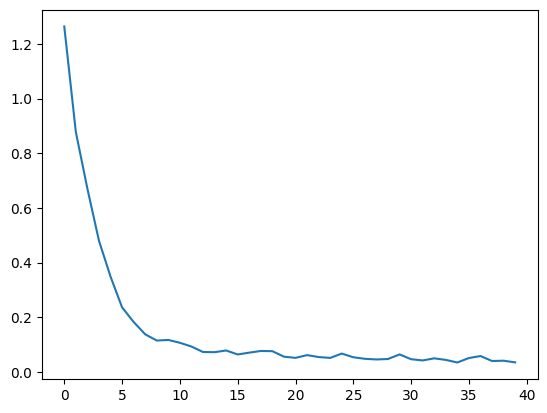

In [24]:
losses = history.history["loss"]
plt.plot(losses)

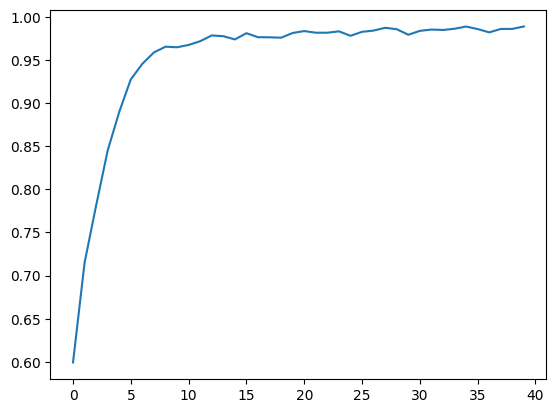

In [25]:
acc = history.history['accuracy']
plt.plot(acc)

# 7| Model predictions

In [26]:
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((160,160)))

In [27]:
def test_predict(test_image):
    result = efficientnet_model.predict(np.asarray([read_img(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

1/1 [==============================] - 6s 6s/step
probability: 94.65942978858948%
Predicted class :  6


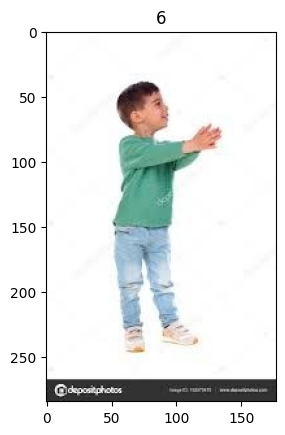

In [28]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1001.jpg")

1/1 [==============================] - 0s 58ms/step
probability: 99.9994158744812%
Predicted class :  4


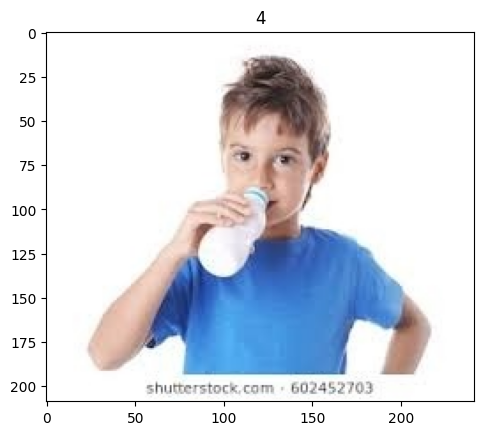

In [29]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_101.jpg")

1/1 [==============================] - 0s 59ms/step
probability: 56.94640278816223%
Predicted class :  11


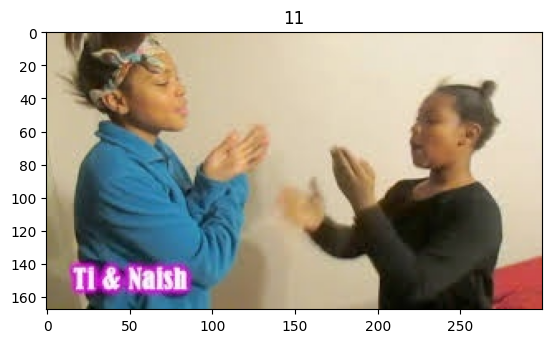

In [30]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1056.jpg")

1/1 [==============================] - 0s 52ms/step
probability: 99.93662238121033%
Predicted class :  14


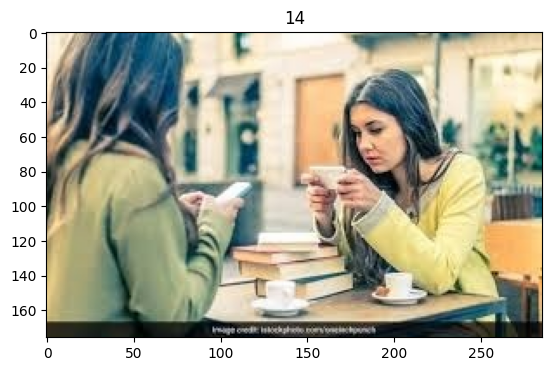

In [31]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1024.jpg")

In [32]:
model.save('my_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

